In [174]:
from sklearn.linear_model import Lasso, Ridge, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import scipy.stats as stats 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from model_builder import ModelBuilder
from CustomRandomForest import CustomRandomForest
from model_utils import *
import shap
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import colorsys
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from sklearn.metrics.pairwise import cosine_similarity
plt.rcParams["font.family"] = "Times New Roman"
import warnings
warnings.filterwarnings("ignore")

# Helpful Functions

In [99]:
# These are the ones we want (for now)
# All Tasks
selected_tasks = ["Writing Story", "Divergent Association", "Wolf Goat Cabbage", "Room Assignment", "Sudoku", "Guess the Correlation", "Allocating Resources", "Moral Reasoning", "Word Construction", "Whac a Mole"]

# These 4 have similar score distributions for Teams with Chat (aka "Similarly Difficult")
# selected_tasks = ["Writing Story", "Divergent Association", "Wolf Goat Cabbage", "Room Assignment"]

# These four have distributions that didn't change acros All Players --> Teams --> Teams with Chat
# aka "Similar Levels of Synergy"
# selected_tasks = ["Allocating Resources", "Sudoku", "Moral Reasoning", "Writing Story"]

# These 2 are different for teams that did and didn't chat
# selected_tasks = ["Room Assignment", "Whac a Mole"]

In [100]:
min_num_chats = 0
data_path = "../output/"
tiny_multitask = 'conv/multi_task_TINY_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage = 'conv/multi_task_output_conversation_level_stageId_cumulative.csv'
multitask_cumulative_by_stage_and_task = 'conv/multi_task_output_conversation_level_stageId_cumulative_within_task.csv'

In [101]:
def drop_invariant_columns(df):
    """
    Certain features are invariant throughout the training data (e.g., the entire column is 0 throughout).

    These feature obviously won't be very useful predictors, so we drop them.
    
    This function works by identifying columns that only have 1 unique value throughout the entire column,
    and then dropping them.

    @df: the dataframe containing the features (this should be X).
    """
    nunique = df.nunique()
    cols_to_drop = nunique[nunique == 1].index
    return(df.drop(cols_to_drop, axis=1))

def read_and_preprocess_data(path, min_num_chats, num_conversation_components = None):
	conv_data  = pd.read_csv(path)

	# Fill NA with mean
	conv_data.fillna(conv_data.mean(numeric_only=True), inplace=True)

	# Filter this down to teams that have at least min_num of chats
	# Can also comment this out to re-run results on *all* conversations!
	conv_data = conv_data[conv_data["sum_num_messages"] >= min_num_chats]

	# Filder this down to the selected tasks
	conv_data = conv_data[conv_data['task'].isin(selected_tasks)]


	# Save the important information

	# DV
	dvs = conv_data[["score","speed","efficiency","raw_duration_min","default_duration_min"]]

	# Team Composition
	composition_colnames = ['birth_year', 'CRT', 'income_max', 'income_min', 'IRCS_GS', 'IRCS_GV', 'IRCS_IB', 'IRCS_IR',
				'IRCS_IV', 'IRCS_RS', 'political_fiscal', 'political_social', 'RME', 'country', 'education_level', 'gender', 'marital_status', 'political_party', 'race', 'playerCount']
	
	# Select columns that contain the specified keywords
	composition = conv_data[[col for col in conv_data.columns if any(keyword in col for keyword in composition_colnames)]]

	# Task
	task = conv_data[['task', 'complexity']].copy()

	task_map_path = '../utils/task_map.csv' # get task map
	task_map = pd.read_csv(task_map_path)

	task_name_mapping = {
		"Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
		"Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
		"Guess the Correlation": "Guessing the correlation",
		"Writing Story": "Writing story",
		"Room Assignment": "Room assignment task",
		"Allocating Resources": "Allocating resources to programs",
		"Divergent Association": "Divergent Association Task",
		"Word Construction": "Word construction from a subset of letters",
		"Whac a Mole": "Whac-A-Mole"
	}
	task.loc[:, 'task'] = task['task'].replace(task_name_mapping)
	task = pd.merge(left=task, right=task_map, on = "task", how='left')
	
	# Create dummy columns for 'complexity'
	complexity_dummies = pd.get_dummies(task['complexity'])
	task = pd.concat([task, complexity_dummies], axis=1)   
	task.drop(['complexity', 'task'], axis=1, inplace=True)

	# Conversation
	conversation = conv_data.drop(columns= list(dvs.columns) + list(composition.columns))._get_numeric_data()
	conversation = drop_invariant_columns(conversation) # drop invariant conv features

	# additional preprocess --- get PC's of conversation to reduce dimensionality issues
	if(num_conversation_components):
		pca = PCA(n_components=num_conversation_components)
		pca_result = pca.fit_transform(conversation.transform(lambda x: (x - x.mean()) / x.std()))
		print("PCA explained variance:")
		print(np.sum(pca.explained_variance_ratio_))
		conversation = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

	return composition, task, conversation, dvs

In [102]:
team_composition_features, task_features, conv_features, targets = read_and_preprocess_data(data_path + multitask_cumulative_by_stage_and_task, min_num_chats=min_num_chats)

In [103]:
tasks = pd.read_csv(data_path + multitask_cumulative_by_stage)["task"].to_frame().rename(columns={"task": "task_name"})
tasks = tasks[tasks['task_name'].isin(selected_tasks)]

# Downstream Exploration: Using Communication Features to Predict the Task

In [119]:
tasks.value_counts()#/len(tasks)

task_name            
Guess the Correlation    130
Moral Reasoning          130
Wolf Goat Cabbage        129
Writing Story            126
Room Assignment          123
Sudoku                   118
Allocating Resources     116
Divergent Association     87
Word Construction         65
Whac a Mole               19
dtype: int64

In [205]:
# Initialize variables to store results
y_test_all = pd.DataFrame(index=y_train.index)
y_predicted_all = pd.DataFrame(columns=y_train.columns)
total_confusion_matrix = np.zeros((len(tasks.task_name.unique()), len(tasks.task_name.unique())))

for i in range(100):
    # Get a random train-test split
    X_train, X_test, y_train, y_test = train_test_split(conv_features, tasks, test_size=0.33, random_state=i)
    
    # Fit a random forest classifier on training data and predict the test data
    clf = RandomForestClassifier(max_depth=10, random_state=19104)
    clf.fit(X_train, y_train)

    y_test_all = pd.concat([y_test_all, y_test], axis = 0)

    # Summarize all the tests so that we can get a global report
    predictions = clf.predict(X_test)
    y_predicted_all = pd.concat([y_predicted_all, pd.DataFrame(predictions)], axis = 0)

    # Get the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    
    # Add the confusion matrix to the total
    total_confusion_matrix += cm

In [172]:
# all confusion matrices
confusion_matrix_sum = pd.DataFrame(total_confusion_matrix, index=list(tasks.task_name.unique()), columns=list(tasks.task_name.unique()))
normalized_confusion_matrix = confusion_matrix_sum.div(confusion_matrix_sum.sum(axis=1), axis=0)

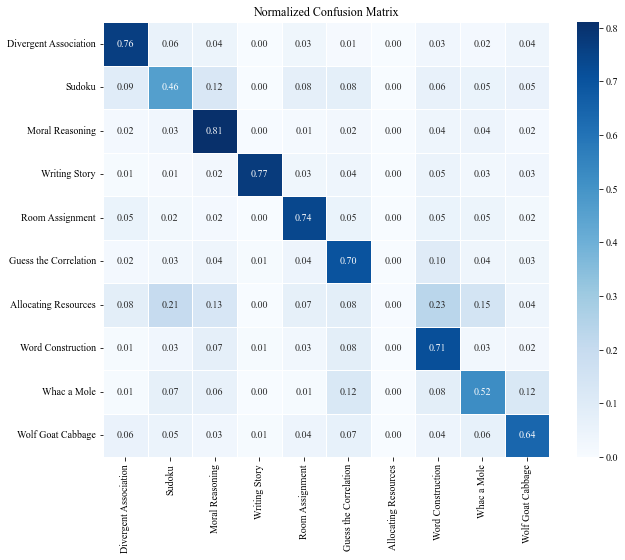

In [180]:
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_confusion_matrix, annot=True, cmap="Blues", fmt=".2f", linewidths=.5)
plt.title('Normalized Confusion Matrix')
plt.show()

In [209]:
# Calculate and print the global classification report
average_classification_report = classification_report(y_test_all.dropna(), y_predicted_all.drop('task_name', axis=1), target_names=list(tasks.task_name.unique()))
print("Global Classification Report:")
print(average_classification_report)

Global Classification Report:
                       precision    recall  f1-score   support

Divergent Association       0.75      0.76      0.76      3877
               Sudoku       0.52      0.46      0.49      2855
      Moral Reasoning       0.70      0.81      0.75      4278
        Writing Story       0.96      0.77      0.86      4257
      Room Assignment       0.74      0.74      0.74      4130
Guess the Correlation       0.62      0.70      0.66      3883
 Allocating Resources       0.08      0.00      0.01       614
    Word Construction       0.63      0.71      0.67      4314
          Whac a Mole       0.46      0.52      0.49      2136
    Wolf Goat Cabbage       0.71      0.64      0.67      4156

             accuracy                           0.69     34500
            macro avg       0.62      0.61      0.61     34500
         weighted avg       0.68      0.69      0.68     34500



In [129]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = conv_features.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importances.head(40)

,importance
average_user_avg_money_lexical_per_100,0.008751
average_user_sum_third_person_lexical_per_100,0.007387
average_user_sum_home_lexical_per_100,0.007258
max_user_avg_home_lexical_per_100,0.006547
average_user_avg_third_person_lexical_per_100,0.006498
stdev_third_person_lexical_per_100,0.006270
average_user_avg_family_lexical_per_100,0.006163
max_user_avg_money_lexical_per_100,0.006157
stdev_user_sum_third_person_lexical_per_100,0.005945
average_money_lexical_per_100,0.005811


In [142]:
explainer = shap.TreeExplainer(clf)
shap_values = np.array(explainer.shap_values(X_train))

In [143]:
print(shap_values.shape)

(10, 698, 1161)


In [157]:
task_list = list(tasks.task_name.unique())
task_list

['Divergent Association',
 'Sudoku',
 'Moral Reasoning',
 'Writing Story',
 'Room Assignment',
 'Guess the Correlation',
 'Allocating Resources',
 'Word Construction',
 'Whac a Mole',
 'Wolf Goat Cabbage']

In [156]:
def find_index(game_name, game_list):
    try:
        index = game_list.index(game_name)
        return index
    except ValueError:
        return f"The game '{game_name}' is not in the list."

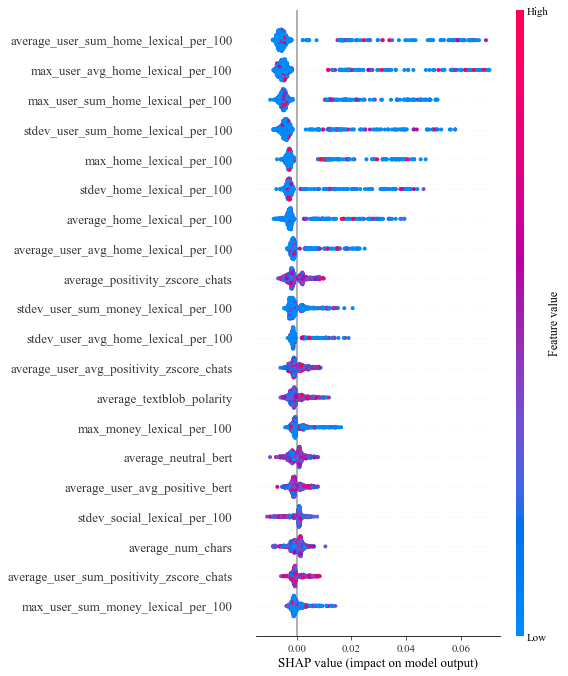

In [212]:
shap.summary_plot(shap_values[find_index("Room Assignment", task_list)],X_train)